# Neural Networks

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List

# Set random seeds
def set_seed(seed: int = 0):
  np.random.seed(seed)
  torch.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

In [65]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class FullyConnected(nn.Module):
         
    def __init__(self, in_features, num_classes, activation = nn.ReLU, num_layers: int = 3):
        assert num_layers % 2 == 1, "Please give an odd number of layers"
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers // 2):
            self.layers.append(nn.Sequential(
                nn.Linear(in_features * (2 ** i), in_features * (2 ** (i + 1)), bias=True),
                activation()
            ))
        for i in reversed(range(num_layers // 2)):
            self.layers.append(nn.Sequential(
                nn.Linear(in_features * (2 ** (i + 1)), in_features * (2 ** i), bias=True),
                activation()
            ))
        self.layers.append(nn.Linear(in_features, num_classes))
        for l in self.layers:
            l.apply(init_weights)
        
    def forward(self, X):
        for l in self.layers:
            X = l(X)
        return X

In [66]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [67]:
# Prepare data

df = np.array(pd.read_csv("fetal_health.csv"), dtype=np.float32)
np.random.shuffle(df)
X = np.array(df[:, :-1])
y = np.array(df[:, -1], dtype=np.int64) - 1 # We subtract 1 to make classes 0,1,2 instead of 1,2,3
num_data = len(y)
num_train = int(np.floor(num_data * 0.6))
num_val = int(np.floor(num_data * 0.2))

train_X = X[:num_train]
train_y = y[:num_train]

val_X = X[num_train:num_train + num_val]
val_y = y[num_train:num_train + num_val]

test_X = X[num_train + num_val:]
test_y = y[num_train + num_val:]

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def calculateAccuracy(dataloader: torch.utils.data.DataLoader, model: nn.Module):
    total = 0
    correct = 0
    model = model.to(device)
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    return accuracy

def train(model: nn.Module, 
        trainset: torch.utils.data.Dataset,
        testset: torch.utils.data.Dataset,
        loss_criterion = nn.CrossEntropyLoss, 
        optimizer = optim.Adam,
        lr: float = 0.001,
        weight_decay: float = 0.001, 
        batch_size: int = 4, 
        num_epochs: int = 50,
        verbose: bool = False):
    set_seed()
    patience = 0
    max_test_acc = -1.0
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)
    model = model.to(device)

    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_criterion = loss_criterion()
    losses = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 4 == 3:    # print every 4 mini-batches
                average_loss = running_loss / 4
                if verbose:
                    print(f'[{epoch + 1}, {i + 1}] loss: {average_loss:.3f}')
                losses.append(average_loss)
                running_loss = 0.0
        
        # End of epoch, calculate accuracies
        train_accuracy = calculateAccuracy(trainloader, model)
        train_accs.append(train_accuracy)
        if verbose:
            print(f'[Epoch {epoch + 1}] Train accuracy:  {train_accuracy:.2f}%')

        test_accuracy = calculateAccuracy(testloader, model)
        test_accs.append(test_accuracy)
        if verbose:
            print(f'[Epoch {epoch + 1}] Test accuracy:  {test_accuracy:.2f}%')
            
        if test_accuracy > max_test_acc:
            max_test_acc = test_accuracy
            patience = 0
        else:
            patience += 1
        
        if patience >= 15:
            print('Patience reached, no improvements for 15 epochs. Early stopping.')
            return losses, train_accs, test_accs
        
    print('Finished Training')   
    return losses, train_accs, test_accs

def plot(labels, loss_lists, train_acc_lists, test_acc_lists):
    for i, loss_list in enumerate(loss_lists): 
        plt.plot(loss_list, label=f"{labels[i]}")
    plt.title("Loss Curve")
    leg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    leg.get_frame().set_alpha(0.5)
    plt.show()

    for i, train_acc_list in enumerate(train_acc_lists):
        plt.plot(train_acc_list, label=f"{labels[i]}")
    plt.title("Training Set Accuracies")
    leg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    leg.get_frame().set_alpha(0.5)
    plt.show()

    for i, test_acc_list in enumerate(test_acc_lists):
        plt.plot(test_acc_list, label=f"{labels[i]}")
    plt.title("Test Set Accuracies")
    leg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    leg.get_frame().set_alpha(0.5)
    plt.show()

In [76]:
loss_criterion_dict = {
    "nn.CrossEntropyLoss": nn.CrossEntropyLoss
}
activation_dict = {
    "nn.PReLU": nn.PReLU, 
    "nn.ReLU": nn.ReLU, 
    "nn.LeakyReLU": nn.LeakyReLU,
    "nn.Tanh": nn.Tanh, 
    "nn.Sigmoid": nn.Sigmoid
}
optimizer_dict = {
    "optim.Adam": optim.Adam,
    "optim.SGD": optim.SGD, 
    "optim.Adagrad": optim.Adagrad,
    "optim.RMSprop": optim.RMSprop
}
class Hyperparam:
  def __init__(self, batch_size: int = 64, lr: float = 1e-2, 
              weight_decay: float = 1e-3, loss_criterion: str = "nn.CrossEntropyLoss",
              num_layers: int = 3, activation: str = "nn.ReLU", optimizer: str = "optim.Adam"):
    super().__init__()
    self.batch_size = batch_size
    self.lr = lr
    self.weight_decay = weight_decay
    self.num_layers = num_layers
    self.loss_criterion = loss_criterion_dict[loss_criterion]
    self.activation = activation_dict[activation]
    self.optimizer = optimizer_dict[optimizer]

hyperparam = Hyperparam()
train_dataset = TabularDataset(train_X, train_y)
val_dataset = TabularDataset(val_X, val_y)


In [77]:
model = FullyConnected(train_X.shape[1], len(np.unique(y)),
                       activation=hyperparam.activation, num_layers=hyperparam.num_layers)


In [78]:
sum(p.numel() for p in model.parameters())


1893

In [79]:
losses, train_accuracies, val_accuracies = train(
  model=FullyConnected(train_X.shape[1], len(np.unique(y)), 
                        activation=hyperparam.activation, num_layers=hyperparam.num_layers),
  trainset=train_dataset,
  testset=val_dataset,
  loss_criterion=hyperparam.loss_criterion,
  lr=hyperparam.lr,
  batch_size=hyperparam.batch_size,
  optimizer=hyperparam.optimizer
)

Patience reached, no improvements for 15 epochs. Early stopping.


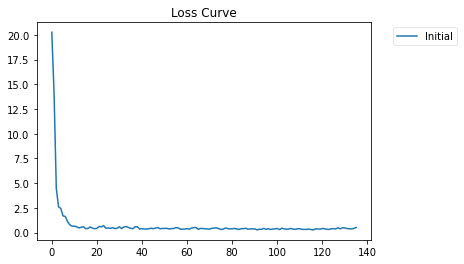

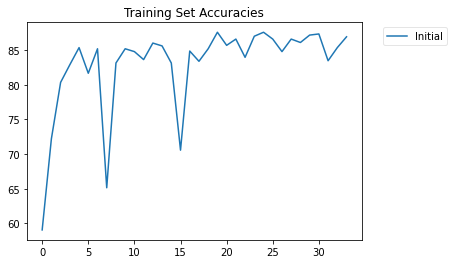

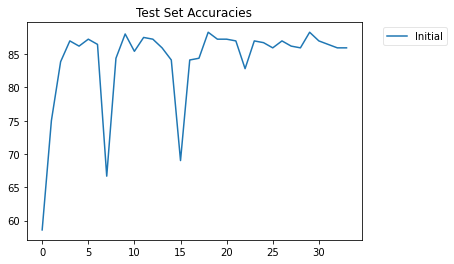

In [80]:
plot(["Initial"], [losses], [train_accuracies], [val_accuracies])

In [81]:
import optuna

In [82]:
def objective(trial):
    hyperparam = Hyperparam(
        batch_size=trial.suggest_categorical("batch_size", [1, 4, 16, 64, 256]),
        lr=trial.suggest_loguniform("lr", 1e-4, 1e-1),
        weight_decay=trial.suggest_loguniform("weight_decay", 1e-5, 1e-3),
        optimizer=trial.suggest_categorical("optimizer", list(optimizer_dict.keys())),
        activation=trial.suggest_categorical("activation", list(activation_dict.keys())),
        loss_criterion=trial.suggest_categorical("loss_criterion", list(loss_criterion_dict.keys())),
        num_layers=trial.suggest_categorical("num_layers", [3, 5, 7])
    )
    _, _, val_accuracies = train(
        model=FullyConnected(train_X.shape[1], len(np.unique(y)),
                             activation=hyperparam.activation, num_layers=hyperparam.num_layers),
        trainset=train_dataset,
        testset=val_dataset,
        loss_criterion=hyperparam.loss_criterion,
        lr=hyperparam.lr,
        batch_size=hyperparam.batch_size,
        optimizer=hyperparam.optimizer
    )
    return val_accuracies[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-02-25 00:04:07,947] A new study created in memory with name: no-name-8412f6c4-b821-4999-bd48-0fd9e03cf545
[I 2022-02-25 00:04:37,821] Trial 0 finished with value: 79.05882352941177 and parameters: {'batch_size': 1, 'lr': 0.027720777971672265, 'weight_decay': 4.352086845316767e-05, 'optimizer': 'optim.RMSprop', 'activation': 'nn.Sigmoid', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 0 with value: 79.05882352941177.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:04:38,305] Trial 1 finished with value: 78.515625 and parameters: {'batch_size': 256, 'lr': 0.0001425868184189085, 'weight_decay': 0.00050989447484736, 'optimizer': 'optim.Adam', 'activation': 'nn.Tanh', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 0 with value: 79.05882352941177.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:04:44,961] Trial 2 finished with value: 85.84905660377359 and parameters: {'batch_size': 4, 'lr': 0.003482650840607596, 'weight_decay': 0.0002775777646786967, 'optimizer': 'optim.Adagrad', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 2 with value: 85.84905660377359.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:04:45,880] Trial 3 finished with value: 86.328125 and parameters: {'batch_size': 256, 'lr': 0.0003691554224926285, 'weight_decay': 0.00018587301616427237, 'optimizer': 'optim.Adagrad', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 3 with value: 86.328125.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:05:12,469] Trial 4 finished with value: 79.05882352941177 and parameters: {'batch_size': 1, 'lr': 0.014422832189749862, 'weight_decay': 0.00010213705418219157, 'optimizer': 'optim.Adam', 'activation': 'nn.Sigmoid', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 3 with value: 86.328125.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:05:39,515] Trial 5 finished with value: 84.0 and parameters: {'batch_size': 1, 'lr': 0.0002166335372514431, 'weight_decay': 0.00020272179128259037, 'optimizer': 'optim.SGD', 'activation': 'nn.Tanh', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 3 with value: 86.328125.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:05:43,380] Trial 6 finished with value: 85.33653846153847 and parameters: {'batch_size': 16, 'lr': 0.001495056873216278, 'weight_decay': 2.8611021313409314e-05, 'optimizer': 'optim.Adagrad', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 3 with value: 86.328125.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:05:58,767] Trial 7 finished with value: 79.05882352941177 and parameters: {'batch_size': 1, 'lr': 0.009511172456914288, 'weight_decay': 1.2239614385976153e-05, 'optimizer': 'optim.RMSprop', 'activation': 'nn.Tanh', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 3 with value: 86.328125.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:05:59,167] Trial 8 finished with value: 78.515625 and parameters: {'batch_size': 256, 'lr': 0.0808525051832032, 'weight_decay': 1.1530859109539811e-05, 'optimizer': 'optim.RMSprop', 'activation': 'nn.Tanh', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 3 with value: 86.328125.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:00,441] Trial 9 finished with value: 85.67708333333333 and parameters: {'batch_size': 64, 'lr': 0.003781096572927568, 'weight_decay': 0.00022340305166251696, 'optimizer': 'optim.RMSprop', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 3 with value: 86.328125.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:01,390] Trial 10 finished with value: 87.109375 and parameters: {'batch_size': 256, 'lr': 0.000561364989786972, 'weight_decay': 0.000948554491156872, 'optimizer': 'optim.Adagrad', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 10 with value: 87.109375.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:02,197] Trial 11 finished with value: 83.203125 and parameters: {'batch_size': 256, 'lr': 0.0007077052618958971, 'weight_decay': 0.0007644847886778139, 'optimizer': 'optim.Adagrad', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 10 with value: 87.109375.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:02,912] Trial 12 finished with value: 87.5 and parameters: {'batch_size': 256, 'lr': 0.0003895045021728581, 'weight_decay': 0.0008187465469994234, 'optimizer': 'optim.Adagrad', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 12 with value: 87.5.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:03,889] Trial 13 finished with value: 86.71875 and parameters: {'batch_size': 256, 'lr': 0.0007296546738027383, 'weight_decay': 0.0009113377720290712, 'optimizer': 'optim.Adagrad', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 12 with value: 87.5.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:14,194] Trial 14 finished with value: 87.5 and parameters: {'batch_size': 4, 'lr': 0.00010815521536678521, 'weight_decay': 0.0004795508471937359, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 12 with value: 87.5.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:25,464] Trial 15 finished with value: 87.73584905660377 and parameters: {'batch_size': 4, 'lr': 0.00011167277020583644, 'weight_decay': 0.0004465021650587067, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 15 with value: 87.73584905660377.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:35,722] Trial 16 finished with value: 88.44339622641509 and parameters: {'batch_size': 4, 'lr': 0.0013718491513540966, 'weight_decay': 0.0004139439197103943, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 16 with value: 88.44339622641509.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:43,452] Trial 17 finished with value: 87.5 and parameters: {'batch_size': 4, 'lr': 0.00174201812174135, 'weight_decay': 0.00010432523017712365, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 16 with value: 88.44339622641509.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:06:59,090] Trial 18 finished with value: 83.9622641509434 and parameters: {'batch_size': 4, 'lr': 0.0014088833024691804, 'weight_decay': 0.0003831381593774794, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 16 with value: 88.44339622641509.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:07:04,700] Trial 19 finished with value: 86.32075471698113 and parameters: {'batch_size': 4, 'lr': 0.00822169670202024, 'weight_decay': 0.00014263591299504345, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 16 with value: 88.44339622641509.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:07:06,689] Trial 20 finished with value: 86.45833333333333 and parameters: {'batch_size': 64, 'lr': 0.0002356273164611769, 'weight_decay': 4.722847968206947e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 16 with value: 88.44339622641509.


Finished Training


[I 2022-02-25 00:07:16,542] Trial 21 finished with value: 88.67924528301887 and parameters: {'batch_size': 4, 'lr': 0.0016916321028262564, 'weight_decay': 8.452236920922415e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:07:38,742] Trial 22 finished with value: 87.97169811320755 and parameters: {'batch_size': 4, 'lr': 0.005208843585178255, 'weight_decay': 5.20085437654383e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:08:01,597] Trial 23 finished with value: 87.02830188679245 and parameters: {'batch_size': 4, 'lr': 0.005079010980662131, 'weight_decay': 5.8660303527661634e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Finished Training


[I 2022-02-25 00:08:05,017] Trial 24 finished with value: 87.98076923076923 and parameters: {'batch_size': 16, 'lr': 0.0019651975584335127, 'weight_decay': 2.1928965178550446e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:08:08,634] Trial 25 finished with value: 83.17307692307692 and parameters: {'batch_size': 16, 'lr': 0.002199890490307757, 'weight_decay': 1.7904094954301085e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:08:20,731] Trial 26 finished with value: 88.46153846153847 and parameters: {'batch_size': 16, 'lr': 0.0012260571999824523, 'weight_decay': 6.235864903396319e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Finished Training


[I 2022-02-25 00:08:26,937] Trial 27 finished with value: 84.85576923076923 and parameters: {'batch_size': 16, 'lr': 0.001037571517938835, 'weight_decay': 7.727771735358127e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:08:42,062] Trial 28 finished with value: 87.74038461538461 and parameters: {'batch_size': 16, 'lr': 0.0010585870960362952, 'weight_decay': 3.3597382400444464e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Finished Training


[I 2022-02-25 00:08:43,382] Trial 29 finished with value: 79.94791666666667 and parameters: {'batch_size': 64, 'lr': 0.028970628367079754, 'weight_decay': 7.40258971206604e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.Sigmoid', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:08:46,407] Trial 30 finished with value: 79.08653846153847 and parameters: {'batch_size': 16, 'lr': 0.0025246839493662213, 'weight_decay': 0.00014811050630062113, 'optimizer': 'optim.Adam', 'activation': 'nn.Sigmoid', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:08:50,095] Trial 31 finished with value: 87.98076923076923 and parameters: {'batch_size': 16, 'lr': 0.0010338572484824727, 'weight_decay': 2.542804190812614e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:08:53,441] Trial 32 finished with value: 88.46153846153847 and parameters: {'batch_size': 16, 'lr': 0.0011269687640409552, 'weight_decay': 3.9694313512865845e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:09:00,319] Trial 33 finished with value: 87.98076923076923 and parameters: {'batch_size': 16, 'lr': 0.0004942503853297783, 'weight_decay': 4.053461879254152e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:09:19,057] Trial 34 finished with value: 88.67924528301887 and parameters: {'batch_size': 4, 'lr': 0.003038538698479707, 'weight_decay': 7.593459468281975e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Finished Training


[I 2022-02-25 00:09:23,572] Trial 35 finished with value: 85.09615384615384 and parameters: {'batch_size': 16, 'lr': 0.0032937102595903918, 'weight_decay': 7.298403613912907e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:09:30,794] Trial 36 finished with value: 87.73584905660377 and parameters: {'batch_size': 4, 'lr': 0.0051350526964992526, 'weight_decay': 0.00012299531578113424, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:10:12,005] Trial 37 finished with value: 83.52941176470588 and parameters: {'batch_size': 1, 'lr': 0.0002686405927530406, 'weight_decay': 3.8174024510012784e-05, 'optimizer': 'optim.RMSprop', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:10:17,469] Trial 38 finished with value: 79.08653846153847 and parameters: {'batch_size': 16, 'lr': 0.01670488414142936, 'weight_decay': 6.223449681059664e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:10:27,529] Trial 39 finished with value: 86.32075471698113 and parameters: {'batch_size': 4, 'lr': 0.0027067675678639704, 'weight_decay': 8.313691111146106e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:11:35,039] Trial 40 finished with value: 85.6470588235294 and parameters: {'batch_size': 1, 'lr': 0.0007907537014577912, 'weight_decay': 0.00010492544638315105, 'optimizer': 'optim.RMSprop', 'activation': 'nn.Tanh', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:11:57,604] Trial 41 finished with value: 86.79245283018868 and parameters: {'batch_size': 4, 'lr': 0.0013263873861064682, 'weight_decay': 0.0003062444350279587, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Finished Training


[I 2022-02-25 00:12:06,173] Trial 42 finished with value: 79.00943396226415 and parameters: {'batch_size': 4, 'lr': 0.00403235848265021, 'weight_decay': 0.00015880375265160492, 'optimizer': 'optim.SGD', 'activation': 'nn.Sigmoid', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:12:14,414] Trial 43 finished with value: 86.55660377358491 and parameters: {'batch_size': 4, 'lr': 0.00793483990694248, 'weight_decay': 8.836313245776324e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:12:16,830] Trial 44 finished with value: 86.97916666666667 and parameters: {'batch_size': 64, 'lr': 0.0017272672703890718, 'weight_decay': 6.10571367820862e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:12:27,542] Trial 45 finished with value: 86.32075471698113 and parameters: {'batch_size': 4, 'lr': 0.0005250724274974154, 'weight_decay': 0.0006409730341649012, 'optimizer': 'optim.SGD', 'activation': 'nn.Tanh', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:12:35,391] Trial 46 finished with value: 88.22115384615384 and parameters: {'batch_size': 16, 'lr': 0.0009273866166640925, 'weight_decay': 0.00024192574236736025, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Finished Training


[I 2022-02-25 00:12:47,553] Trial 47 finished with value: 87.5 and parameters: {'batch_size': 4, 'lr': 0.0026968662864195947, 'weight_decay': 3.222664251071584e-05, 'optimizer': 'optim.RMSprop', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:13:57,282] Trial 48 finished with value: 86.82352941176471 and parameters: {'batch_size': 1, 'lr': 0.0012895242688121613, 'weight_decay': 1.5095118645771248e-05, 'optimizer': 'optim.Adagrad', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:14:25,830] Trial 49 finished with value: 88.20754716981132 and parameters: {'batch_size': 4, 'lr': 0.00032668573189978476, 'weight_decay': 0.00017599623150573246, 'optimizer': 'optim.Adam', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:14:26,438] Trial 50 finished with value: 78.515625 and parameters: {'batch_size': 256, 'lr': 0.0005557625421747948, 'weight_decay': 0.00011845609581915393, 'optimizer': 'optim.SGD', 'activation': 'nn.Tanh', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 21 with value: 88.67924528301887.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:14:32,756] Trial 51 finished with value: 88.70192307692308 and parameters: {'batch_size': 16, 'lr': 0.0008632163969209217, 'weight_decay': 0.000309988244631267, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Finished Training


[I 2022-02-25 00:14:37,778] Trial 52 finished with value: 87.01923076923077 and parameters: {'batch_size': 16, 'lr': 0.000714722056899267, 'weight_decay': 0.0006181712761967128, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Finished Training


[I 2022-02-25 00:14:42,361] Trial 53 finished with value: 86.77884615384616 and parameters: {'batch_size': 16, 'lr': 0.0015604729237781055, 'weight_decay': 0.0003474246785443569, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:14:44,411] Trial 54 finished with value: 86.53846153846153 and parameters: {'batch_size': 16, 'lr': 0.00215899298636504, 'weight_decay': 5.196975349295552e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:14:48,176] Trial 55 finished with value: 86.29807692307692 and parameters: {'batch_size': 16, 'lr': 0.0004331812662074856, 'weight_decay': 0.00028270845460434414, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:14,139] Trial 56 finished with value: 88.20754716981132 and parameters: {'batch_size': 4, 'lr': 0.0008031446197553063, 'weight_decay': 0.0004060036366229908, 'optimizer': 'optim.Adagrad', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Finished Training


[I 2022-02-25 00:15:15,140] Trial 57 finished with value: 86.45833333333333 and parameters: {'batch_size': 64, 'lr': 0.00015067893461731405, 'weight_decay': 0.0005339797913764702, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:23,149] Trial 58 finished with value: 79.00943396226415 and parameters: {'batch_size': 4, 'lr': 0.001245716683987975, 'weight_decay': 0.00021214487611655254, 'optimizer': 'optim.SGD', 'activation': 'nn.Sigmoid', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:28,073] Trial 59 finished with value: 88.46153846153847 and parameters: {'batch_size': 16, 'lr': 0.0040241147886132325, 'weight_decay': 4.598276275273907e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:34,108] Trial 60 finished with value: 84.375 and parameters: {'batch_size': 16, 'lr': 0.004141348592906634, 'weight_decay': 4.090937617437317e-05, 'optimizer': 'optim.RMSprop', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:37,213] Trial 61 finished with value: 87.98076923076923 and parameters: {'batch_size': 16, 'lr': 0.006366987807191596, 'weight_decay': 6.407979303904031e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:40,048] Trial 62 finished with value: 87.98076923076923 and parameters: {'batch_size': 16, 'lr': 0.001955234816431141, 'weight_decay': 4.740561774896543e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 51 with value: 88.70192307692308.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:45,332] Trial 63 finished with value: 88.9423076923077 and parameters: {'batch_size': 16, 'lr': 0.002998201721534034, 'weight_decay': 2.6045708823841885e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Finished Training


[I 2022-02-25 00:15:50,388] Trial 64 finished with value: 86.77884615384616 and parameters: {'batch_size': 16, 'lr': 0.012621628947363392, 'weight_decay': 2.522246863765397e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:55,126] Trial 65 finished with value: 87.74038461538461 and parameters: {'batch_size': 16, 'lr': 0.0030005843827358293, 'weight_decay': 1.8061465061721997e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Finished Training


[I 2022-02-25 00:15:58,386] Trial 66 finished with value: 87.25961538461539 and parameters: {'batch_size': 16, 'lr': 0.003742298229770812, 'weight_decay': 9.260748387031114e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:15:59,075] Trial 67 finished with value: 82.8125 and parameters: {'batch_size': 256, 'lr': 0.00234076324623003, 'weight_decay': 3.2638710697016335e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:05,656] Trial 68 finished with value: 86.77884615384616 and parameters: {'batch_size': 16, 'lr': 0.0018444641176201735, 'weight_decay': 2.50211094638204e-05, 'optimizer': 'optim.Adagrad', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:11,966] Trial 69 finished with value: 88.46153846153847 and parameters: {'batch_size': 16, 'lr': 0.005713266315019513, 'weight_decay': 5.2861161482832966e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:14,041] Trial 70 finished with value: 82.6923076923077 and parameters: {'batch_size': 16, 'lr': 0.006735366791951857, 'weight_decay': 6.874238932006897e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:19,409] Trial 71 finished with value: 86.77884615384616 and parameters: {'batch_size': 16, 'lr': 0.010572182420006784, 'weight_decay': 4.86197282179239e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:24,186] Trial 72 finished with value: 87.25961538461539 and parameters: {'batch_size': 16, 'lr': 0.0031932474582067, 'weight_decay': 3.639565160761494e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:26,988] Trial 73 finished with value: 85.57692307692308 and parameters: {'batch_size': 16, 'lr': 0.0044921664856723935, 'weight_decay': 5.614383388473315e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:29,197] Trial 74 finished with value: 79.08653846153847 and parameters: {'batch_size': 16, 'lr': 0.09146633170903942, 'weight_decay': 4.385816610848864e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:48,055] Trial 75 finished with value: 79.05882352941177 and parameters: {'batch_size': 1, 'lr': 0.01944696432935565, 'weight_decay': 2.8706709988300003e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:49,761] Trial 76 finished with value: 79.08653846153847 and parameters: {'batch_size': 16, 'lr': 0.0015788993084752216, 'weight_decay': 7.96953467038562e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.Sigmoid', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:52,580] Trial 77 finished with value: 81.25 and parameters: {'batch_size': 16, 'lr': 0.006004289641564575, 'weight_decay': 0.0001165151644197234, 'optimizer': 'optim.SGD', 'activation': 'nn.Tanh', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:54,544] Trial 78 finished with value: 86.71875 and parameters: {'batch_size': 64, 'lr': 0.0011601907950550682, 'weight_decay': 5.525860644243848e-05, 'optimizer': 'optim.Adam', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:16:55,555] Trial 79 finished with value: 85.9375 and parameters: {'batch_size': 256, 'lr': 0.0008731706016082039, 'weight_decay': 4.522732955705219e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.PReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:17:01,606] Trial 80 finished with value: 87.25961538461539 and parameters: {'batch_size': 16, 'lr': 0.0006839238354062705, 'weight_decay': 2.1327423887266407e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 63 with value: 88.9423076923077.


Finished Training


[I 2022-02-25 00:17:18,914] Trial 81 finished with value: 89.15094339622641 and parameters: {'batch_size': 4, 'lr': 0.0014589308571839224, 'weight_decay': 9.583002028793958e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:17:28,048] Trial 82 finished with value: 79.95283018867924 and parameters: {'batch_size': 4, 'lr': 0.0030400414533528312, 'weight_decay': 9.564630353937163e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:17:45,775] Trial 83 finished with value: 87.5 and parameters: {'batch_size': 4, 'lr': 0.00235243163082754, 'weight_decay': 7.142355009284839e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Finished Training


[I 2022-02-25 00:17:54,022] Trial 84 finished with value: 84.90566037735849 and parameters: {'batch_size': 4, 'lr': 0.0010166620104883608, 'weight_decay': 0.00010332397095096398, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:17:57,773] Trial 85 finished with value: 79.08653846153847 and parameters: {'batch_size': 16, 'lr': 0.04339535531296543, 'weight_decay': 0.00013036128792082773, 'optimizer': 'optim.RMSprop', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:18:13,043] Trial 86 finished with value: 89.15094339622641 and parameters: {'batch_size': 4, 'lr': 0.0014996225057390168, 'weight_decay': 8.474877366693818e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:18:27,854] Trial 87 finished with value: 88.91509433962264 and parameters: {'batch_size': 4, 'lr': 0.0006383750282004773, 'weight_decay': 7.859850377991597e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:18:36,289] Trial 88 finished with value: 87.02830188679245 and parameters: {'batch_size': 4, 'lr': 0.0006155945677433657, 'weight_decay': 8.490554358608398e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:18:40,822] Trial 89 finished with value: 51.41509433962264 and parameters: {'batch_size': 4, 'lr': 0.00149104619451972, 'weight_decay': 0.00010489363206475074, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 3}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:18:58,495] Trial 90 finished with value: 88.67924528301887 and parameters: {'batch_size': 4, 'lr': 0.00045663263217662556, 'weight_decay': 0.00018377462007806064, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:19:11,205] Trial 91 finished with value: 88.67924528301887 and parameters: {'batch_size': 4, 'lr': 0.0008685007222648033, 'weight_decay': 0.00016737080777112846, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:19:23,398] Trial 92 finished with value: 87.73584905660377 and parameters: {'batch_size': 4, 'lr': 0.00031736626351983776, 'weight_decay': 0.00017360829932266597, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:19:42,050] Trial 93 finished with value: 88.67924528301887 and parameters: {'batch_size': 4, 'lr': 0.0009244844128457178, 'weight_decay': 0.00025112879684228626, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:19:57,894] Trial 94 finished with value: 88.20754716981132 and parameters: {'batch_size': 4, 'lr': 0.0004566394686976575, 'weight_decay': 0.0002576027313539161, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:20:12,138] Trial 95 finished with value: 88.44339622641509 and parameters: {'batch_size': 4, 'lr': 0.000400086899615839, 'weight_decay': 0.00018997775587075802, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:20:41,978] Trial 96 finished with value: 87.5 and parameters: {'batch_size': 4, 'lr': 0.0006286364739618342, 'weight_decay': 0.00031117945216496413, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Finished Training


[I 2022-02-25 00:21:00,671] Trial 97 finished with value: 88.20754716981132 and parameters: {'batch_size': 4, 'lr': 0.0008895017236752518, 'weight_decay': 1.0196751728914653e-05, 'optimizer': 'optim.Adagrad', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:21:07,061] Trial 98 finished with value: 76.65094339622641 and parameters: {'batch_size': 4, 'lr': 0.0007779455511116452, 'weight_decay': 0.0002316421554427953, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 5}. Best is trial 81 with value: 89.15094339622641.


Patience reached, no improvements for 15 epochs. Early stopping.


[I 2022-02-25 00:21:24,439] Trial 99 finished with value: 87.26415094339623 and parameters: {'batch_size': 4, 'lr': 0.0016675086771044297, 'weight_decay': 0.00012932487695927332, 'optimizer': 'optim.SGD', 'activation': 'nn.ReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}. Best is trial 81 with value: 89.15094339622641.


Finished Training


In [83]:
print("Best hyperparameters are:", study.best_params)
print("Best validation accuracy is:", study.best_value)


Best hyperparameters are: {'batch_size': 4, 'lr': 0.0014589308571839224, 'weight_decay': 9.583002028793958e-05, 'optimizer': 'optim.SGD', 'activation': 'nn.LeakyReLU', 'loss_criterion': 'nn.CrossEntropyLoss', 'num_layers': 7}
Best validation accuracy is: 89.15094339622641
